# Processo seletivo -  iFood

In [283]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
sns.set(rc={'figure.figsize':(15, 6)})

In [3]:
df = pd.read_csv('ml_project1_data.csv')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

# Tratamento de variáveis:
Income: tratar valores nulos -> tranformar em média, porque os dados são centralizados.

Year_Birth: transformar anos iniciados com '18' em '19' e substituir valor 1900 por média da variável

Marital_Status: transformar Alone, YOLO e Absurd em Others

In [5]:
def tratamento_variaveis(df):
    df['Income'].fillna(round(df['Income'].mean(), 2), inplace=True)
    df['Year_Birth'] = df['Year_Birth'].astype(str).replace(r'^18', '19', regex=True).astype(int)
    df['Year_Birth'].replace(1900, int(df['Year_Birth'].mean()), inplace=True)
    df['Marital_Status'].replace(['Alone', 'YOLO', 'Absurd'], 'Others', inplace=True)
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
    df['Income'].replace(666666.0, df['Income'].mean(), inplace=True)

In [6]:
df[((df.Income > 500000))]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
2233,9432,1977,Graduation,Together,666666.0,1,0,2013-06-02,23,9,...,6,0,0,0,0,0,0,3,11,0


In [7]:
tratamento_variaveis(df)

# Criação de variáveis

In [8]:
def criacao_variaveis(df):
    df['Age'] = 2021 - df['Year_Birth']
    df['TotalAccep'] = df.iloc[:, [20, 21, 22, 23, 24, 28]].sum(axis = 1, skipna = True)
    df['NumKidsHome'] = df['Kidhome'] + df['Teenhome']
    df['YearMonthCustomer'] = df['Dt_Customer'].dt.strftime('%Y-%m')
    df['YearCustomer'] = df['Dt_Customer'].dt.strftime('%Y')

In [9]:
criacao_variaveis(df)

In [10]:
def calculo_rfm(new_df):
    new_df['ID'] = df['ID']
    new_df['Recency'] = df['Recency']
    new_df['Frequency'] = df.iloc[:, 15:19].sum(axis = 1, skipna = True)
    new_df['TotalMnt'] = df.iloc[:, 9:15].sum(axis = 1, skipna = True)
    new_df['AvgMntperPurchase'] = round(new_df['TotalMnt'] / new_df['Frequency'], 0)
    new_df['AvgMntperPurchase'].replace(np.inf, 0, inplace=True)
    new_df["RecencyScore"] = pd.cut(new_df["Recency"], 
                                bins=[-1, 
                                np.percentile(new_df["Recency"], 25), 
                                np.percentile(new_df["Recency"], 50), 
                                np.percentile(new_df["Recency"], 75), 
                                            new_df["Recency"].max()], 
                                labels=[4, 3, 2, 1]).astype("int")
    new_df["FrequencyScore"] = pd.cut(new_df["Frequency"], 
                                bins=[-1, 
                                np.percentile(new_df["Frequency"], 25), 
                                np.percentile(new_df["Frequency"], 50), 
                                np.percentile(new_df["Frequency"], 75), 
                                             new_df["Frequency"].max()], 
                                labels=[1, 2, 3, 4]).astype("int")
    new_df["MonetaryScore"] = pd.cut(new_df["TotalMnt"], 
                                bins=[-1, 
                                np.percentile(new_df["TotalMnt"], 25), 
                                np.percentile(new_df["TotalMnt"], 50), 
                                np.percentile(new_df["TotalMnt"], 75), 
                                             new_df["TotalMnt"].max()], 
                                labels=[1, 2, 3, 4]).astype("int")
    new_df['RFM'] = round((new_df["RecencyScore"] + new_df["FrequencyScore"] + new_df["MonetaryScore"]) / 3, 0)

df_rfm = pd.DataFrame()
calculo_rfm(df_rfm)

In [11]:
df = df.merge(df_rfm[['ID', 'Frequency', 'TotalMnt', 'RFM', 'AvgMntperPurchase']], on='ID', how='left')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Response,Age,TotalAccep,NumKidsHome,YearMonthCustomer,YearCustomer,Frequency,TotalMnt,RFM,AvgMntperPurchase
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,1,64,1,0,2012-09,2012,25,1617,3.0,65.0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,67,0,2,2014-03,2014,6,27,2.0,4.0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,56,0,0,2013-08,2013,21,776,3.0,37.0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,37,0,1,2014-02,2014,8,53,2.0,7.0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,40,0,1,2014-01,2014,19,422,2.0,22.0


# Análise exploratória de dados

# 1) Visão geral de vendas

Ao analisar os gastos dos clientes com diferentes segmentos de produtos, percebe-se que o segmento que mais gera receita são os vinhos. Ofertas que focam nesse segmento de produto podem apresentar melhores resultados. Também nota-se que há um maior número de pedidos em loja física que no site e um maior número de pedidos do catálogo que em produtos com desconto, o que pode significar que os clientes não estão tão preocupados com o preço do produto.

Os dados mostram que não há uma correlação significativa entre mais visitas ao site e compras mais recentes. Além disso, há uma correlação negativa entre mais visitas ao site e um maior gasto em compras. Portanto, o site pode ser analisado para repensar o funil de compras.

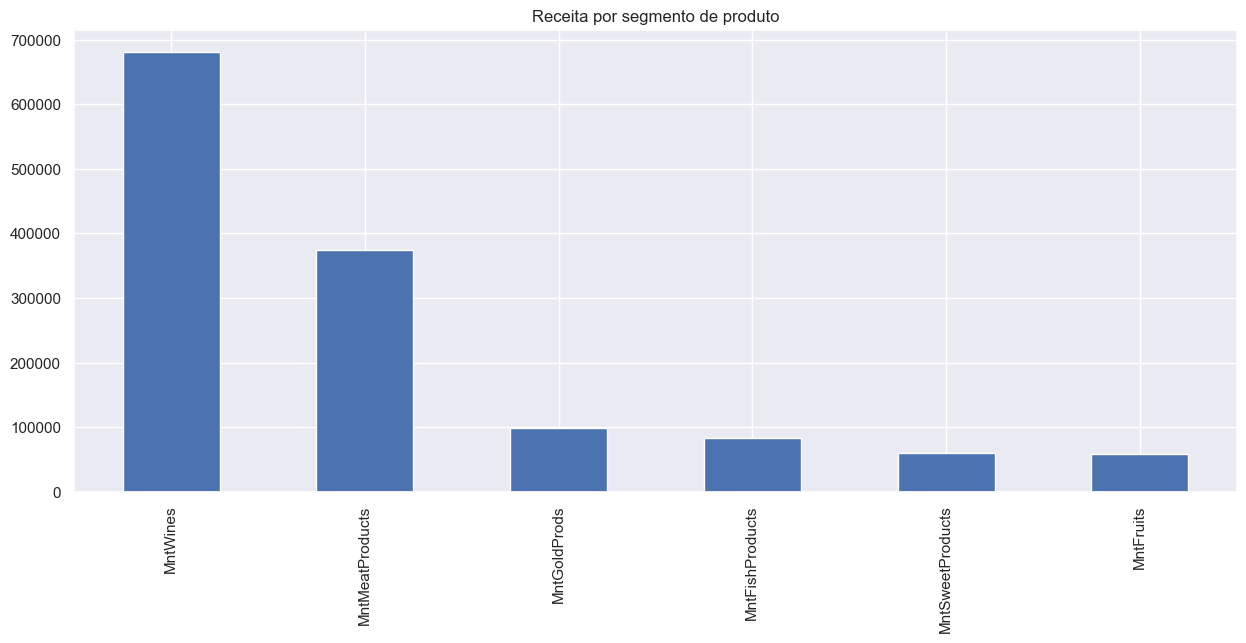

In [12]:
df.iloc[:, 9:15].sum().sort_values(ascending=False).plot.bar(title='Receita por segmento de produto')
plt.show()

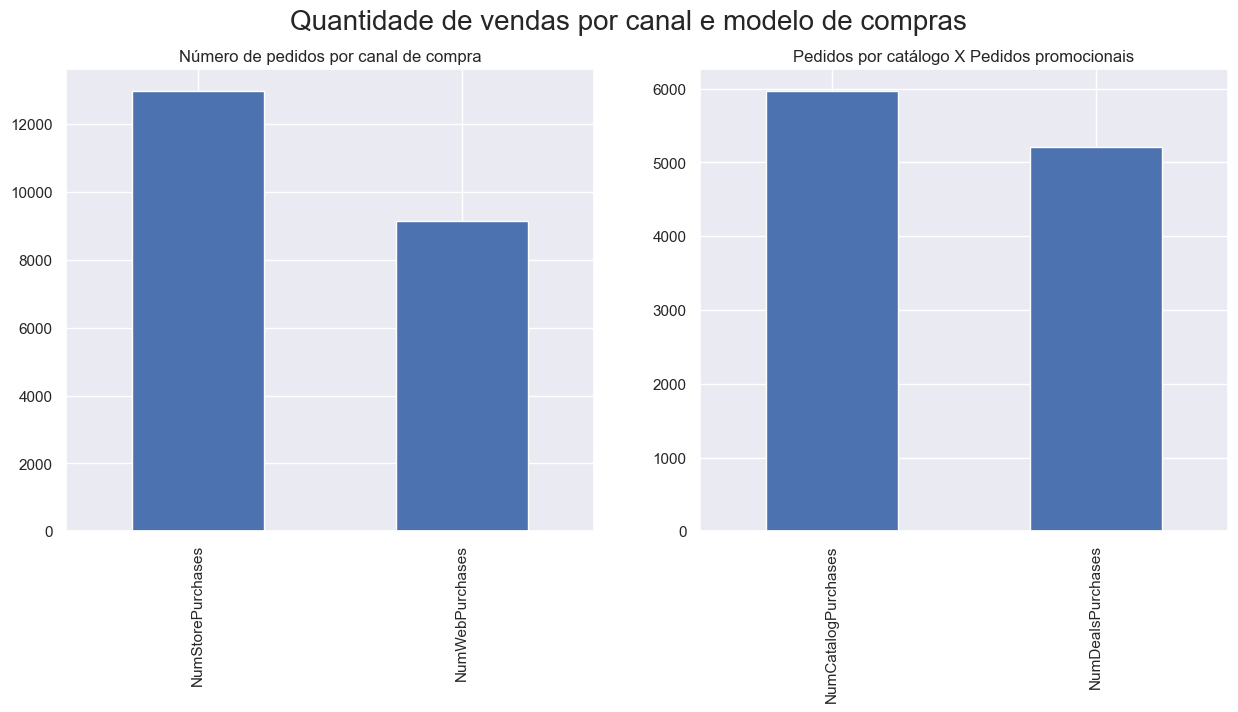

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.suptitle("Quantidade de vendas por canal e modelo de compras", fontsize=20)

graph1 = df.loc[:, ['NumWebPurchases', 'NumStorePurchases']].sum().sort_values(ascending=False).plot.bar(ax=axes[0])
graph2 = df.loc[:, ['NumDealsPurchases', 'NumCatalogPurchases']].sum().sort_values(ascending=False).plot.bar(ax=axes[1])

graph1.set_title("Número de pedidos por canal de compra")
graph2.set_title("Pedidos por catálogo X Pedidos promocionais")
plt.show()

In [14]:
corr1 = df.loc[:, ['Recency', 'NumWebVisitsMonth']].corr()
corr2 = df.loc[:, ['TotalMnt', 'NumWebVisitsMonth']].corr()
print('Correlação entre visitas mensais ao site e recência de compras: ' + str(round(corr1['NumWebVisitsMonth']['Recency'], 2)))
print('Correlação entre visitas mensais ao site e total de gastos: ' + str(round(corr2['NumWebVisitsMonth']['TotalMnt'], 2)))

Correlação entre visitas mensais ao site e recência de compras: -0.02
Correlação entre visitas mensais ao site e total de gastos: -0.5


# 2) Dados demográficos do público selecionado

Os clientes selecionados tem renda anual de até 163 mil (excluindo um outlier de 666 mil). Além disso, a maioria dos clientes tem nível de escolaridade de no mínimo graduação, estão em um casamento ou união estável e tem entre 0 e 1 filhos em casa.

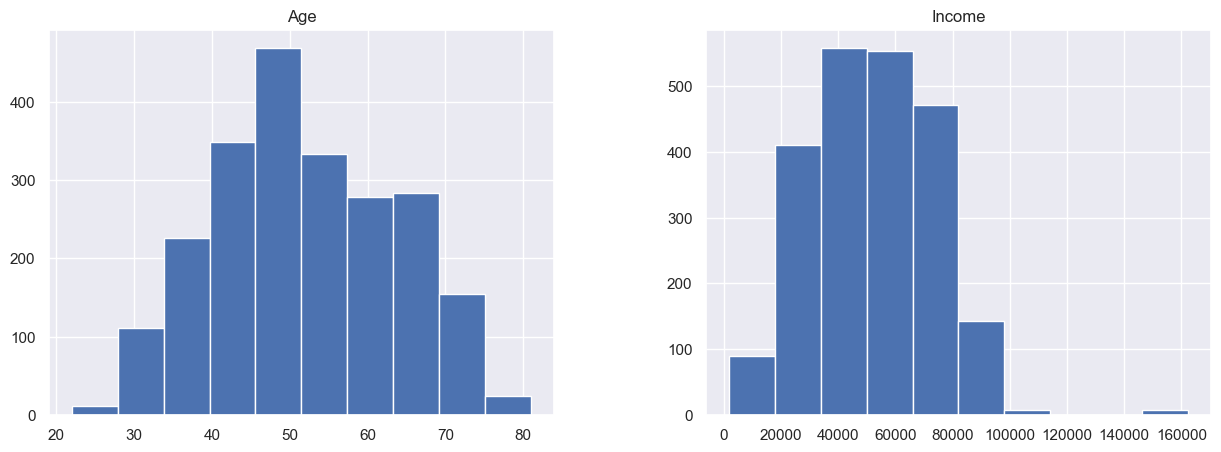

In [15]:
sns.set(rc={'figure.figsize':(15, 5)})
df.loc[:, ['Age', 'Income']].hist()
plt.show()

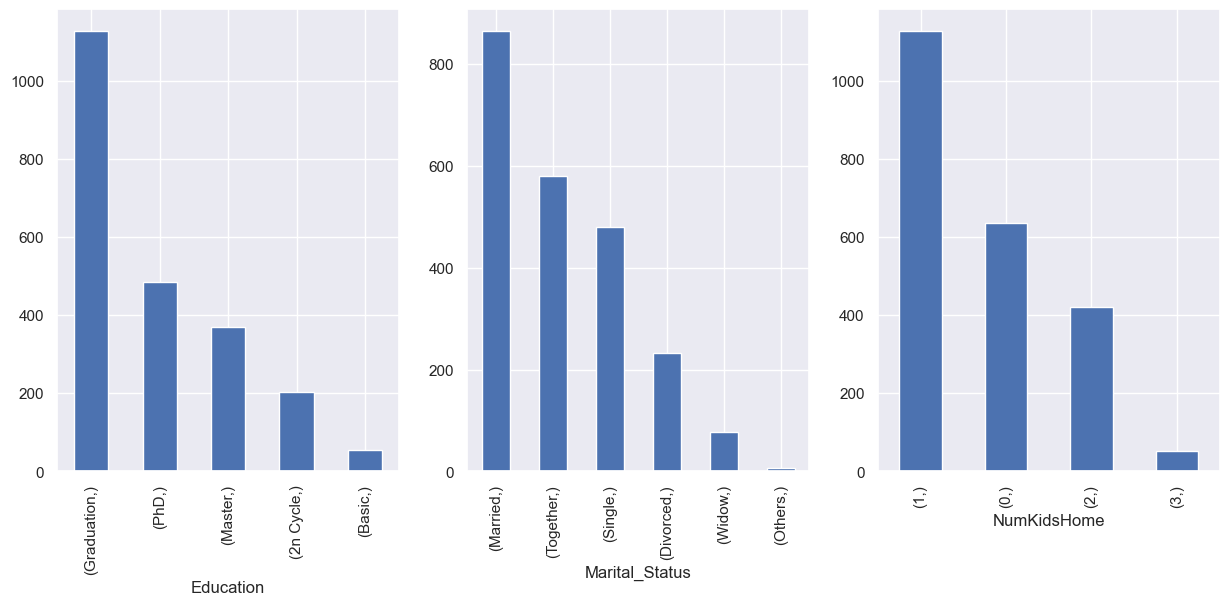

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,6))

df.loc[:, ['Education']].value_counts().plot.bar(ax=axes[0])
df.loc[:, ['Marital_Status']].value_counts().plot.bar(ax=axes[1])
df.loc[:, ['NumKidsHome']].value_counts().plot.bar(ax=axes[2])
plt.show()

# 3) Análise de campanhas

Para analisar o histórico das campanhas, criou-se uma variável TotalAccep, que representa o número de ofertas aceitas pelo cliente (incluindo aceites da campanha pioto). Além disso, separou-se os clientes em dois grupos: clientes que não aceitaram nenhuma das ofertas e clientes que aceitaram pelo menos uma das ofertas.

Percebe-se que as últimas três campanhas e o piloto tiveram um maior número de aceites, o que é uma boa tendência de melhoria das campanhas. Existe uma correlação positiva entre o número total de ofertas aceitas e o score RFM dos clientes (principalmente nas variáveis frequência e total gasto). Também há uma correlação positiva entre o total de ofertas e a renda do cliente. Também há uma correlação positiva entre o total de ofertas aceitas e o número de compras pela internet e pelo catálogo.

Os gráficos também corroboram com o fato de que parece haver uma correlação positiva entre ofertas aceitas e score RFM e renda do cliente. Esses indícios serão investigados mais a fundo no próximo tópico.

Por fim, é interessante notar que clientes mais antigos aderiram mais a pelo menos uma oferta.

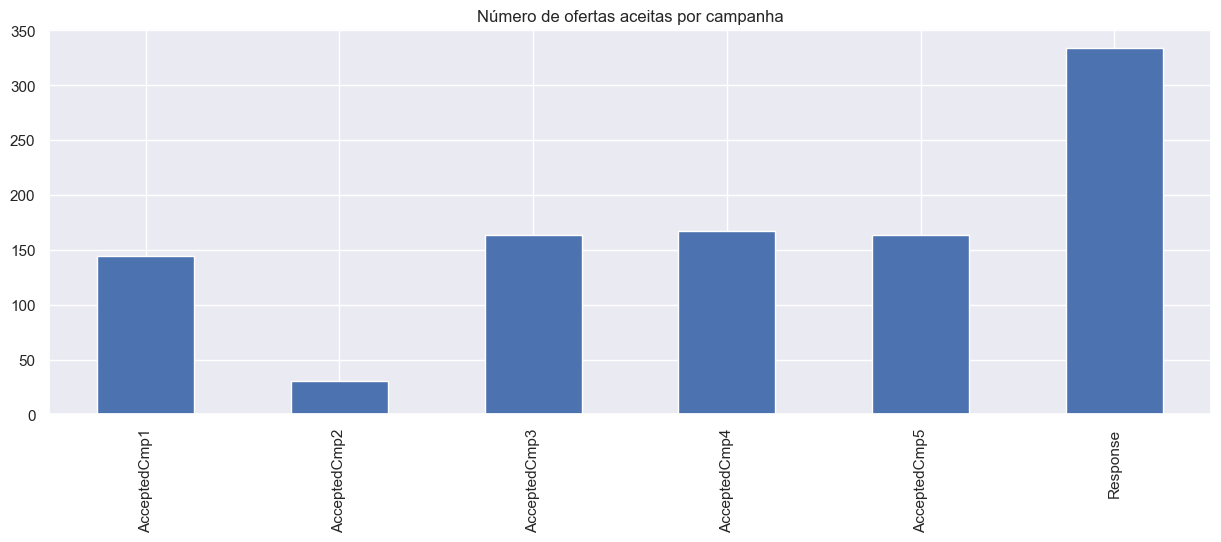

In [17]:
df.loc[:, ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].sum().plot.bar(title='Número de ofertas aceitas por campanha')
plt.show()

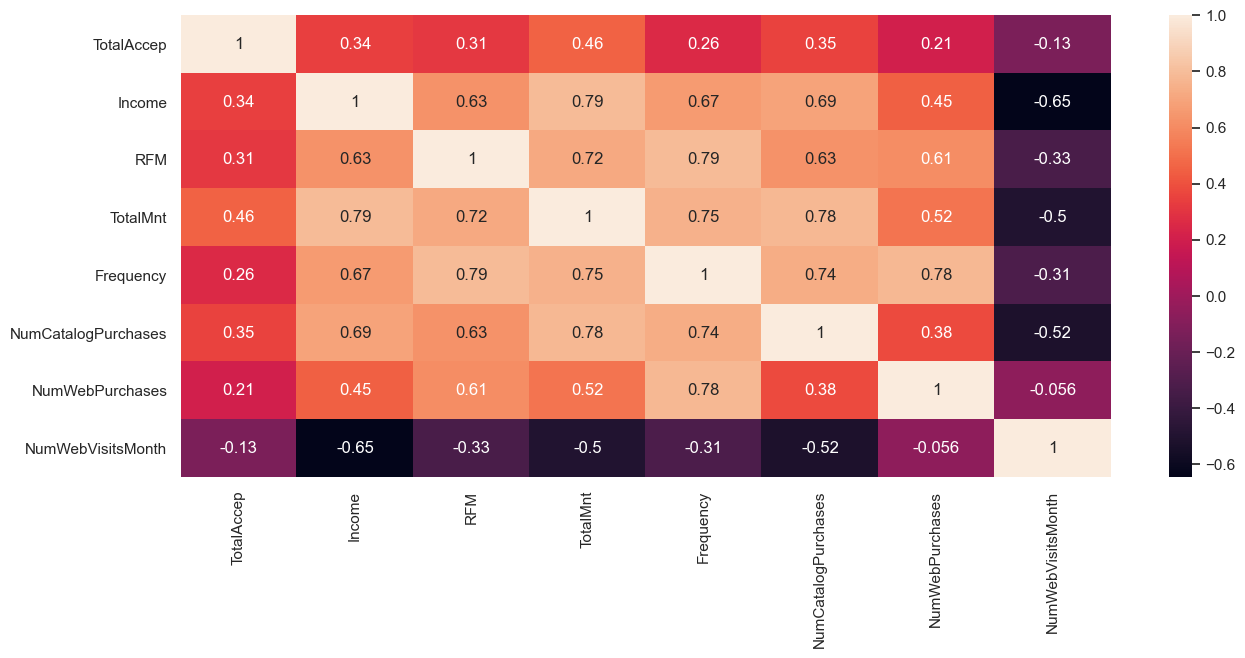

In [18]:
plt.figure(figsize=(15, 6))
sns.heatmap(df.loc[:, ['TotalAccep', 'Income', 'RFM', 'TotalMnt', 'Frequency', 'NumCatalogPurchases', 'NumWebPurchases', 'NumWebVisitsMonth']].corr(), annot=True, cmap='rocket')
plt.show()

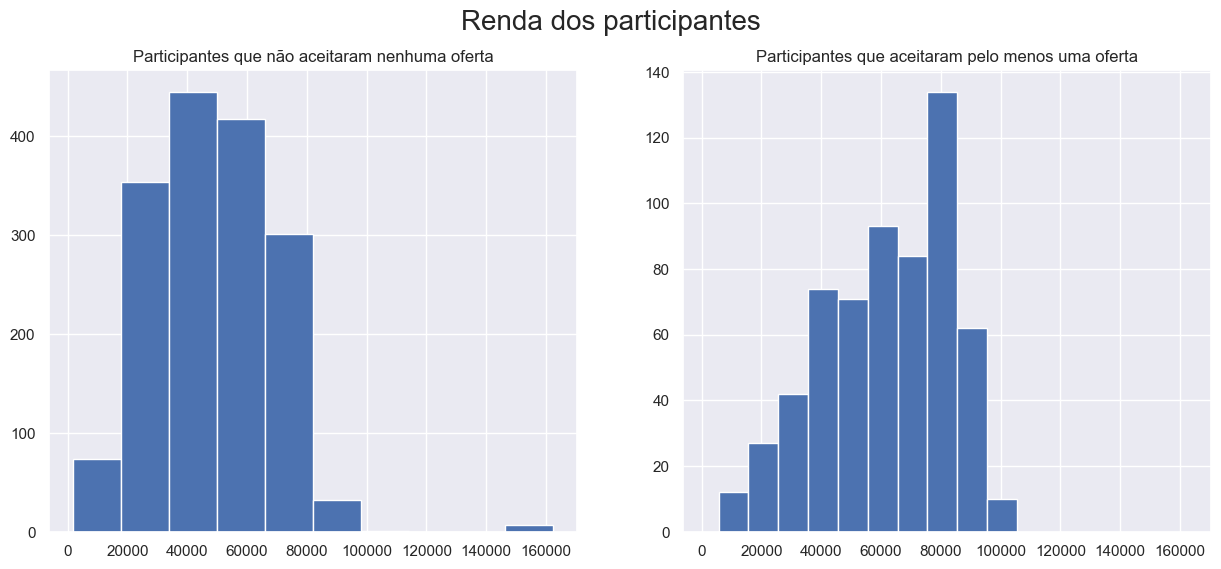

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharex=True)
fig.suptitle("Renda dos participantes", fontsize=20)

hist1 = df.loc[(df.TotalAccep == 0), 'Income'].hist(ax=axes[0])
hist2 = df.loc[(df.TotalAccep != 0), 'Income'].hist(ax=axes[1])
hist2.set_title('Participantes que aceitaram pelo menos uma oferta')
hist1.set_title('Participantes que não aceitaram nenhuma oferta')
plt.show()

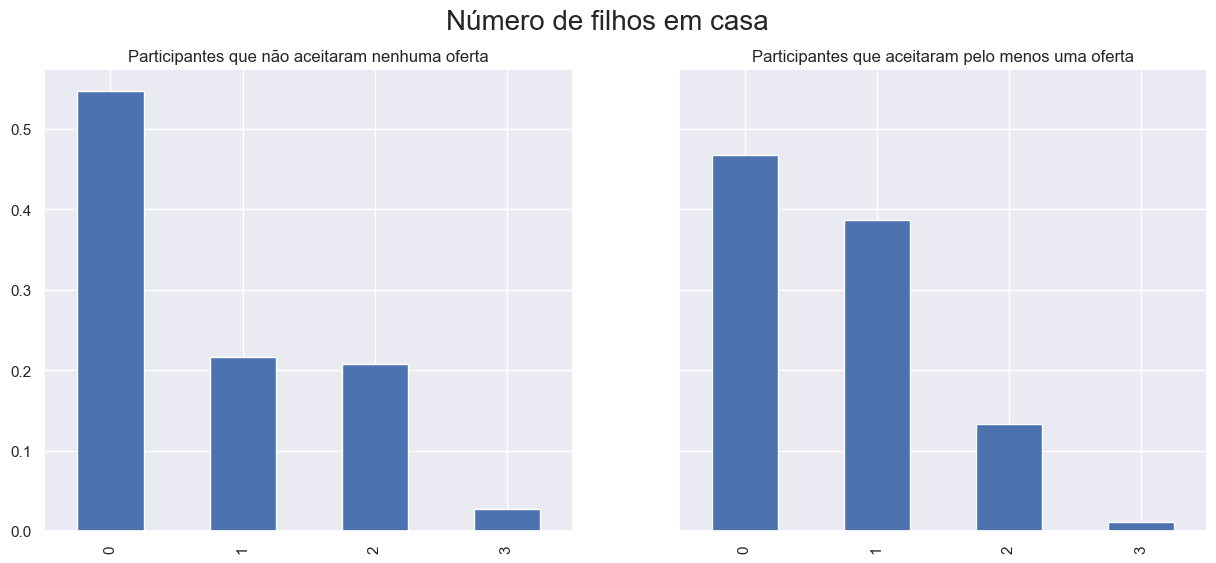

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharex=True, sharey=True)
fig.suptitle("Número de filhos em casa", fontsize=20)
graph1 = df.loc[(df.TotalAccep == 0), 'NumKidsHome'].value_counts(normalize=True).plot.bar(ax=axes[0])
graph2 = df.loc[(df.TotalAccep != 0), 'NumKidsHome'].value_counts(normalize=True).plot.bar(ax=axes[1])
graph1.set_title('Participantes que não aceitaram nenhuma oferta')
graph2.set_title('Participantes que aceitaram pelo menos uma oferta')
plt.show()

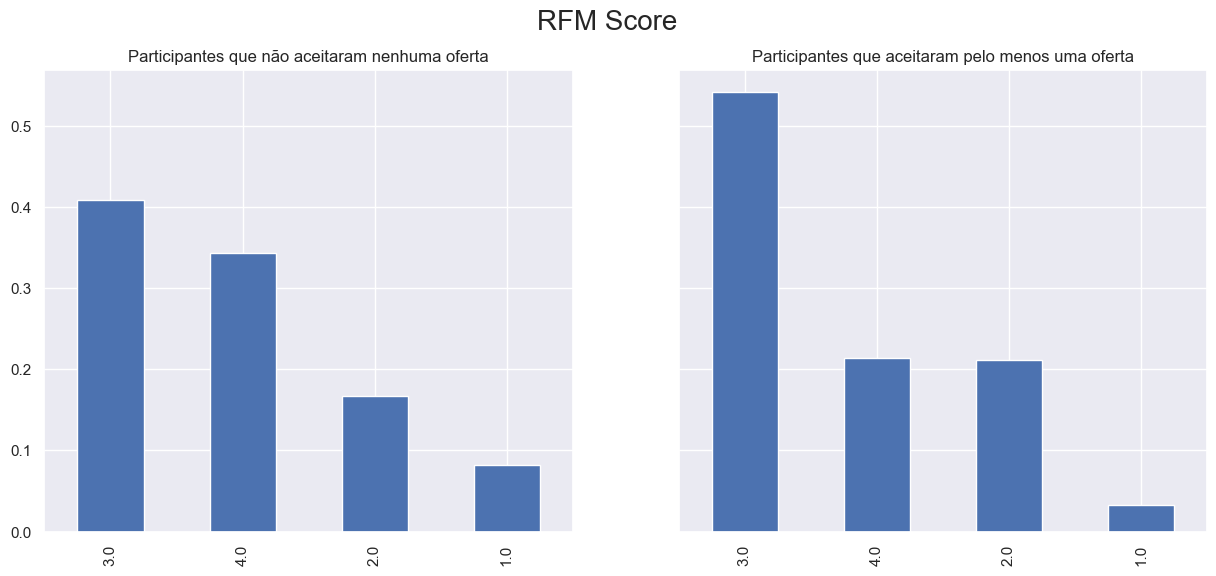

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharex=True, sharey=True)
fig.suptitle('RFM Score', fontsize=20)
graph1 = df.loc[(df.TotalAccep == 0), 'RFM'].value_counts(normalize=True).plot.bar(ax=axes[0])
graph2 = df.loc[(df.TotalAccep != 0), 'RFM'].value_counts(normalize=True).plot.bar(ax=axes[1])
graph1.set_title('Participantes que não aceitaram nenhuma oferta')
graph2.set_title('Participantes que aceitaram pelo menos uma oferta')
plt.show()

In [22]:
histCustomer = df.loc[:, ['YearCustomer', 'Recency', 'Response']][(df.Response == 1)].groupby('YearCustomer')
histCustomer['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
YearCustomer,,,,,,,,
2012,132.0,41.348485,27.798892,1.0,15.00,40.0,60.00,99.0
2013,154.0,34.759740,28.069721,0.0,11.00,26.5,60.00,98.0
2014,48.0,20.979167,19.711202,0.0,4.75,16.0,30.25,81.0


In [23]:
histCustomer = df.loc[:, ['YearCustomer', 'Recency', 'Response']][(df.Response == 0)].groupby('YearCustomer')
histCustomer['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
YearCustomer,,,,,,,,
2012,362.0,53.215470,29.275802,0.0,29.0,55.0,78.75,99.0
2013,1035.0,51.470531,28.229336,0.0,28.0,52.0,75.50,99.0
2014,509.0,50.394892,28.558878,0.0,26.0,50.0,76.00,99.0


# 4) Segmentação de clientes por RFM

A segmentação dos clientes pelo score RFM (explicar o que significa na parte do cálculo) permite concluir que os clientes com score 3 e 4 aderiram significativamente mais à campanha piloto. Isso significa que os clientes com esses score tem maior probabilidade de aderir à oferta.

Ao analisar dados demográficos e comportamento de consumo, percebe-se que há correlações positivas entre o aumento do score RFM e a renda do cliente, assim como com a média de gastos por compra do mesmo. Portanto, clientes com maior renda e com uma maior média de gastos por compra tem maior probabilidade de terem altos score RFM. Os clientes com maior renda também tendem a ter um montante de gastos maior na loja.
Também nota-se uma correlação negativa entre o aumento do score e o número de filhos em casa, o que faz sentido ao pensar que clientes com menos filhos podem ter parte maior da renda destinada a gastos supérfluos (mudar termo). 

Ao verificar os dados demográficos para cada score RFM, observa-se que clientes com score 3 e 4 tendem a possuir graus mais altos de escolaridade e clientes de score 3 estão em sua maioria casados ou em união estável. Não se percebe variações de faixa etária nos diferentes score (trocar score para ranking? colocar porcentagem nos gráficos de barra stacked?).

# 4.1) RFM e aceite de oferta piloto

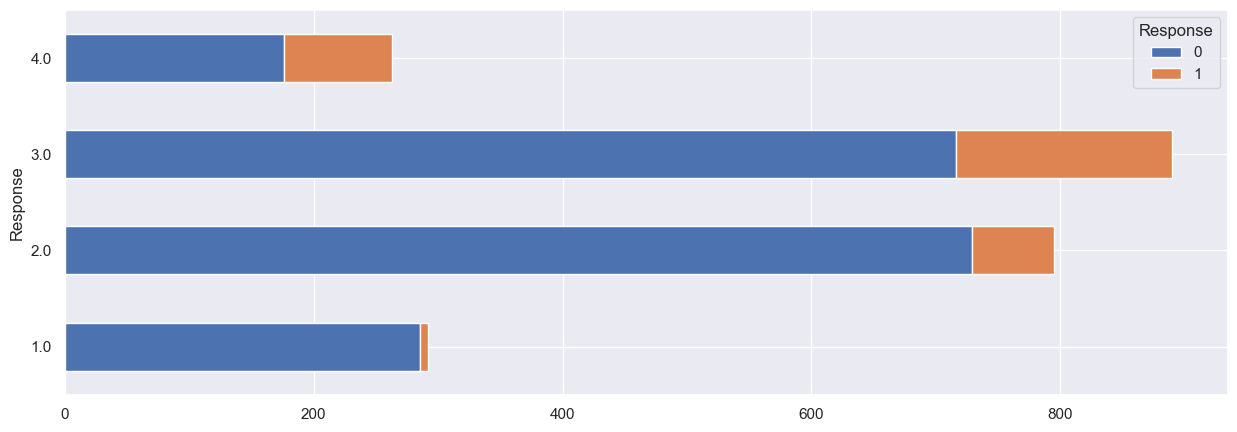

In [24]:
df_edu_rfm = df.loc[:, ['Response', 'RFM']]
df_grouped = df_edu_rfm.groupby(['Response', 'RFM']).agg(count=('Response', 'count')).reset_index()
df_pivot = df_grouped.pivot(index='RFM', columns='Response', values='count')
df_pivot.plot.barh(xlabel='Response', stacked=True)
plt.show()

In [25]:
df_pivot['No %'] = df_pivot[0] / (df_pivot[0] + df_pivot[1])
df_pivot['Yes %'] = df_pivot[1] / (df_pivot[0] + df_pivot[1])
df_pivot

Response,0,1,No %,Yes %
RFM,,,,
1.0,285,7,0.976027,0.023973
2.0,729,66,0.916981,0.083019
3.0,716,174,0.804494,0.195506
4.0,176,87,0.669202,0.330798


# 4.2) RFM, renda e gastos

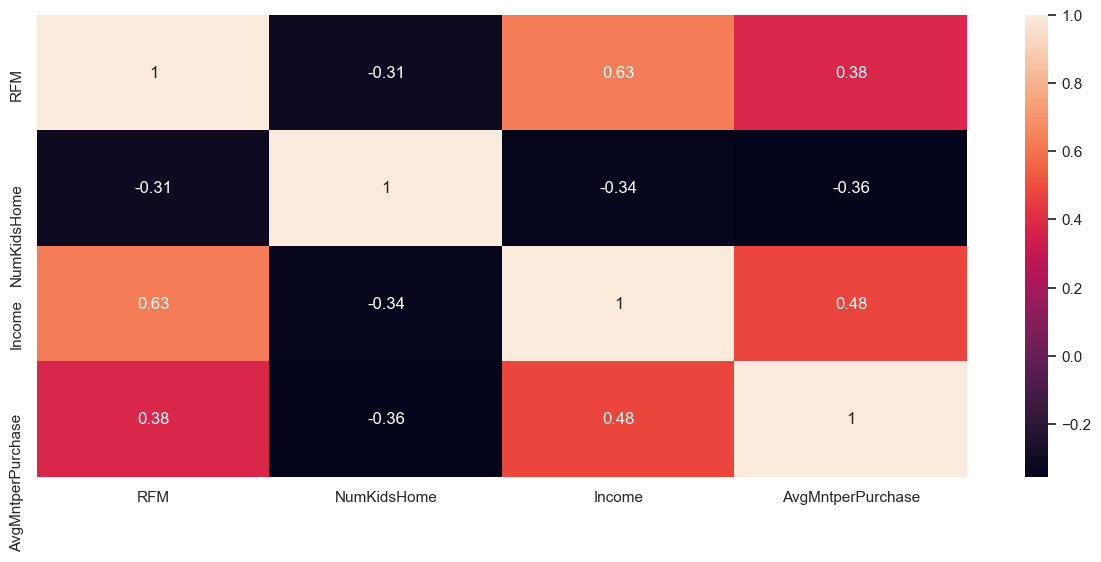

In [26]:
plt.figure(figsize=(15, 6))
sns.heatmap(df.loc[:, ['RFM', 'NumKidsHome', 'Income', 'AvgMntperPurchase']].corr(), annot=True, cmap='rocket')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


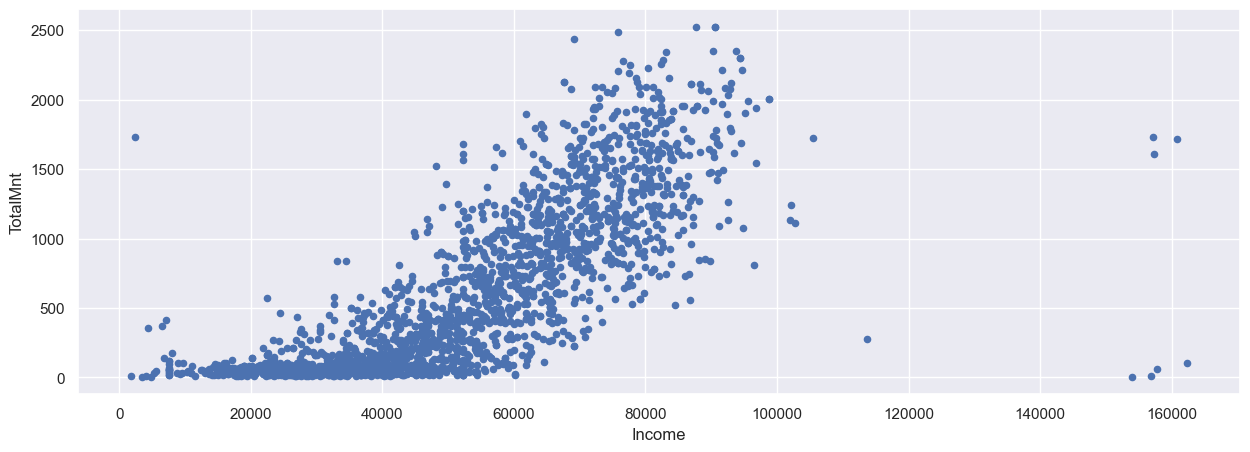

Correlação entre renda e total de gastos: 0.79


In [27]:
incomeSpendingGraph = df.plot.scatter(x='Income', y='TotalMnt')
plt.show()
incomeSpendingcorr = df.loc[:, ['Income', 'TotalMnt']].corr()
print('Correlação entre renda e total de gastos: ' + str(round(incomeSpendingcorr['TotalMnt']['Income'], 2)))

# 4.3) RFM por dados demográficos

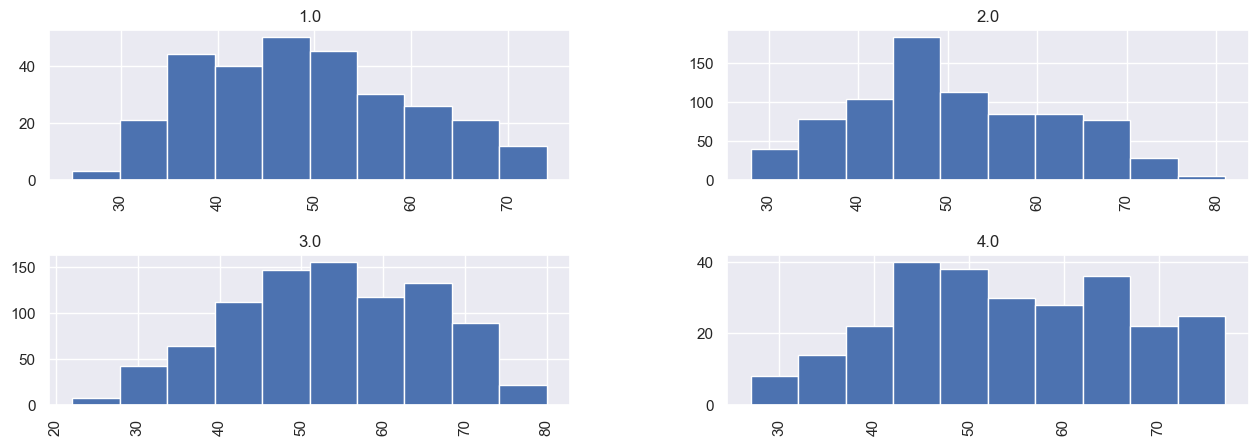

In [28]:
df.hist(column='Age', by='RFM')
plt.show()

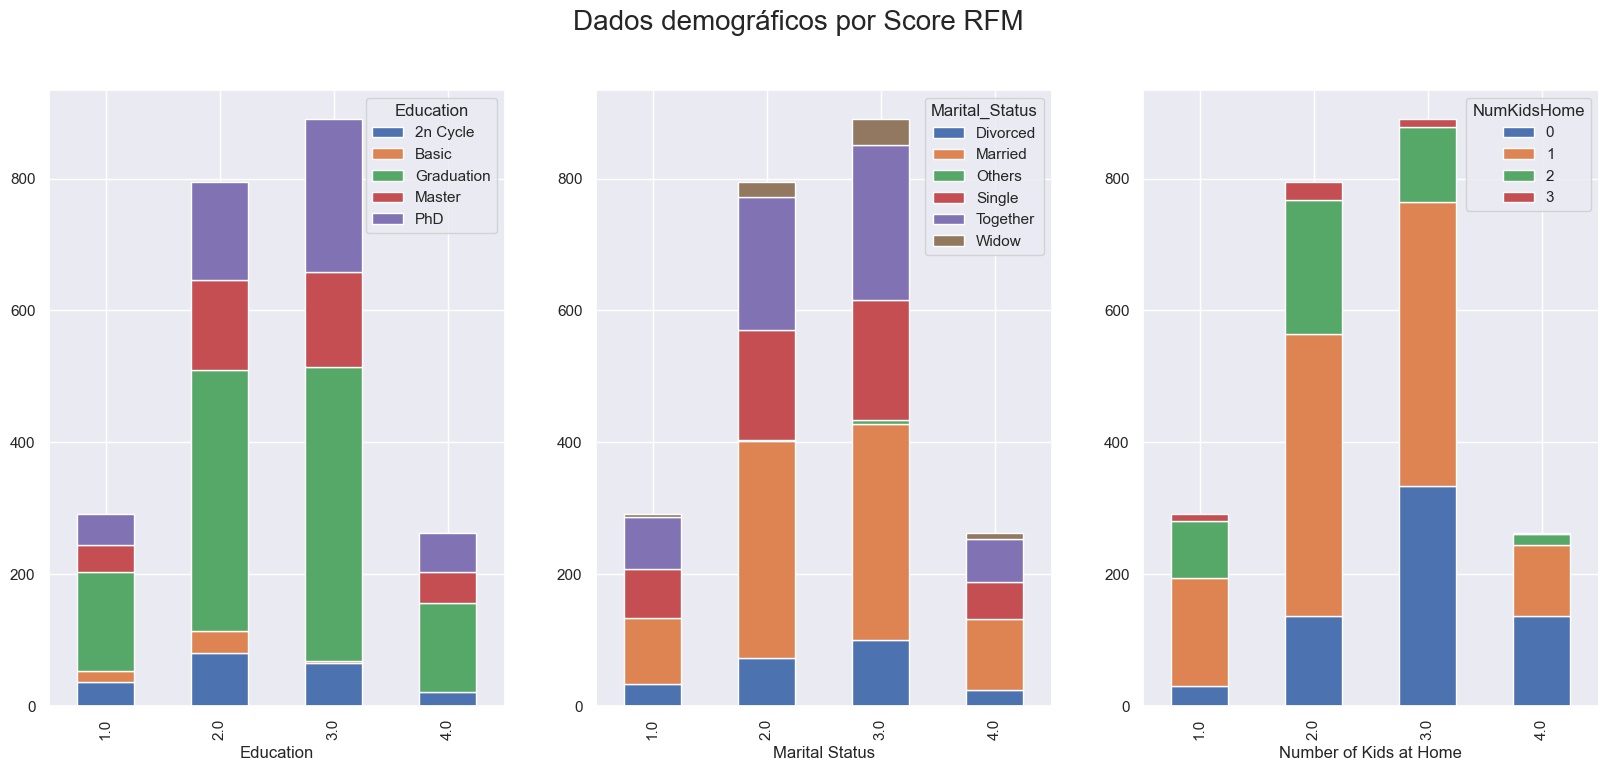

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
fig.suptitle("Dados demográficos por Score RFM", fontsize=20)

df_edu_rfm = df.loc[:, ['Education', 'RFM']]
df_grouped = df_edu_rfm.groupby(['Education', 'RFM']).agg(count=('Education', 'count')).reset_index()
df_pivot = df_grouped.pivot(index='RFM', columns='Education', values='count')
graph1 = df_pivot.plot.bar(xlabel='Education', stacked=True, ax=axes[0])

df_edu_rfm = df.loc[:, ['Marital_Status', 'RFM']]
df_grouped = df_edu_rfm.groupby(['Marital_Status', 'RFM']).agg(count=('Marital_Status', 'count')).reset_index()
df_pivot = df_grouped.pivot(index='RFM', columns='Marital_Status', values='count')
graph2 = df_pivot.plot.bar(xlabel='Marital Status', stacked=True, ax=axes[1])

df_edu_rfm = df.loc[:, ['NumKidsHome', 'RFM']]
df_grouped = df_edu_rfm.groupby(['NumKidsHome', 'RFM']).agg(count=('NumKidsHome', 'count')).reset_index()
df_pivot = df_grouped.pivot(index='RFM', columns='NumKidsHome', values='count')
graph3 = df_pivot.plot.bar(xlabel='Number of Kids at Home', stacked=True, ax=axes[2])
plt.show()

# Segmentação de clientes

A partir da análise exploratória, foi possível perceber variáveis que impactam na probabilidade do cliente aceitar a oferta: renda e nível de escolaridade do cliente, número de filhos em casa e índice de engajamento medido pelo score RFM.

Portanto, essas variáveis foram usadas para criar uma segmentação dos clientes a partir de um algoritmo de clusterização. A análise usou o algoritmo K-Means e se baseou em uma análise de variáveis categóricas. Para tanto, a variável renda foi transformada em três níveis por meio de uma análise da distribuição da variável: baixa (até 40.000,00), média (entre 40.000,00 e 60.000,00) e alta (acima de 60.000,00). Além disso, todas as variáveis foram tratadas pelo algoritmo Ordinal Encoder, como forma de transformar as variáveis em númericas e ordinais. A variável número de filhos não trouxe diferenciações nas segmentações, portanto, foi retirada da modelagem.

A segmentação criada permite estabelecer perfis de consumidores e direcionar de forma mais efetiva as campanhas.

Cluster 0: clientes predominantemente com scores RFM 3 e 4, média mínima de 40.000,00 e todos possuem nível de escolaridade em mestrado e doutorado. Esses clientes demonstraram um alto nível de aceitação de ofertas anteriores.
Cluster 1: clientes de índice RFM 1, 2 e 3 (principalmente 2), com renda anual de até 60.000,00 e com nível de escolaridade de graduação e mestrado. Esses clientes tem um histórico baixo de aceite de ofertas, com exceção da campanha piloto.
Cluster 2: clientes com score RFM 3 e 4, possuem renda anual de pelo menos 40.000,00 e nível de escolaridade de ensino médio ou graduação. Esses clientes apresentam um altíssimo nível de aceitação de ofertas.
Cluster 3: clientes com scores RFM predominantemente 1 e 2, índices mais baixos de renda (apresentado pelo histograma com cauda à direita e possuem nível de escolaridade de nível básico e ensino médio. Esses clientes tem o pior histórico de aceite de ofertas.
Cluster 4: clientes com scores RFM predominantemente 1 e 2, renda de até 70.000,00 com nível de escolaridade de mestrado e doutorado. Esses clientes possuem um histórico ruim de aceite de campanhas.

A partir dos clusters, é possível perceber que os clientes da loja podem ser segmentados de acordo com variáveis relacionadas ao poder aquisitivo (renda, nível de escolaridade) e ao nível de engajamento com a marca. Portanto, conclui-se que clientes com maiores níveis de renda e engajamento possuem um melhor histórico de aceite de ofertas, enquanto clientes com níveis mais baixos de renda e engajamento tendem a não aceitar as ofertas das campanhas. O nível de escolaridade não deve ser usado como variável única para definir se o cliente provavelmente aceitará ou não a oferta, mas pode ser usada como método de seleção de clientes quando combinada com variáveis de renda e engajamento.

Assim, as próximas campanhas podem criar mensagens para os públicos selecionados, aumentando o engajamento dos públicos que já participam das ofertas (clusters 0 e 2) e gerando participação de grupos que geralmente não são impactados pelas campanhas (grupos os clusters 1, 3 e 4).

# 1) Preparação da base de dados

In [127]:
cluster_df = df.loc[:, ['Income', 'Education', 'RFM']]
cluster_df['Income'] = cluster_df['Income'].apply(lambda x: 0 if (x <= 40000) else x) # baixa
cluster_df['Income'] = cluster_df['Income'].apply(lambda x: 1 if (x > 40000 and x <= 60000) else x) # média
cluster_df['Income'] = cluster_df['Income'].apply(lambda x: 2 if (x > 60000) else x) # alta
cluster_df.head()

,Income,Education,RFM
0,58138.0,Graduation,3.0
1,46344.0,Graduation,2.0
2,71613.0,Graduation,3.0
3,26646.0,Graduation,2.0
4,58293.0,PhD,2.0


# 2) Clustering

In [130]:
oe = OrdinalEncoder()
column_transform = make_column_transformer((oe, ['Income', 'Education', 'RFM']))
cluster_df = column_transform.fit_transform(cluster_df)

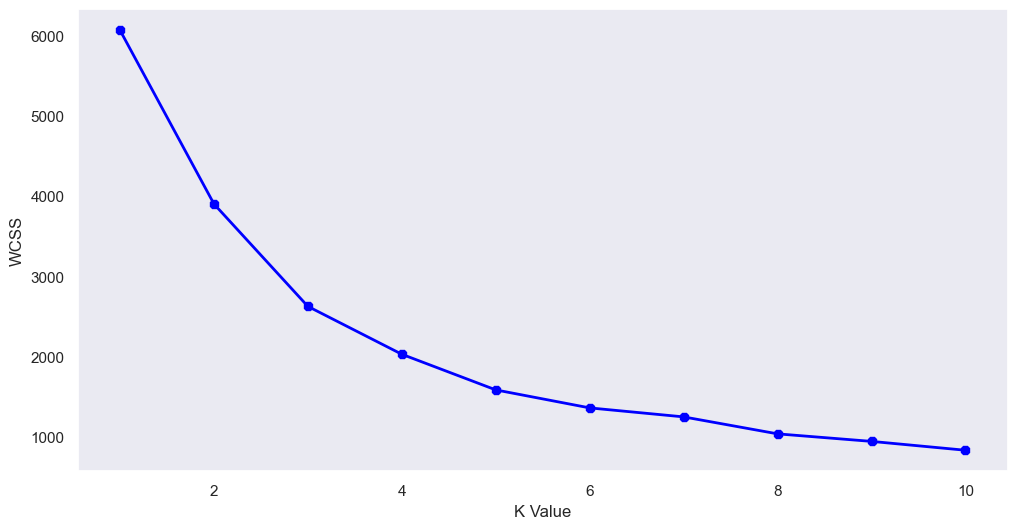

In [132]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(cluster_df)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12, 6))
plt.grid()
plt.plot(range(1,11), wcss, linewidth=2, color='blue', marker='8')
plt.xlabel('K Value')
plt.ylabel('WCSS')
plt.show()

In [133]:
# NÃO RODAR MAISSS
kmeans = KMeans(n_clusters=5)
cluster = kmeans.fit_predict(cluster_df, random_state=32)
df['Cluster'] = cluster

array([2, 1, 2, ..., 2, 0, 4])

# 3) Resultados da segmentação

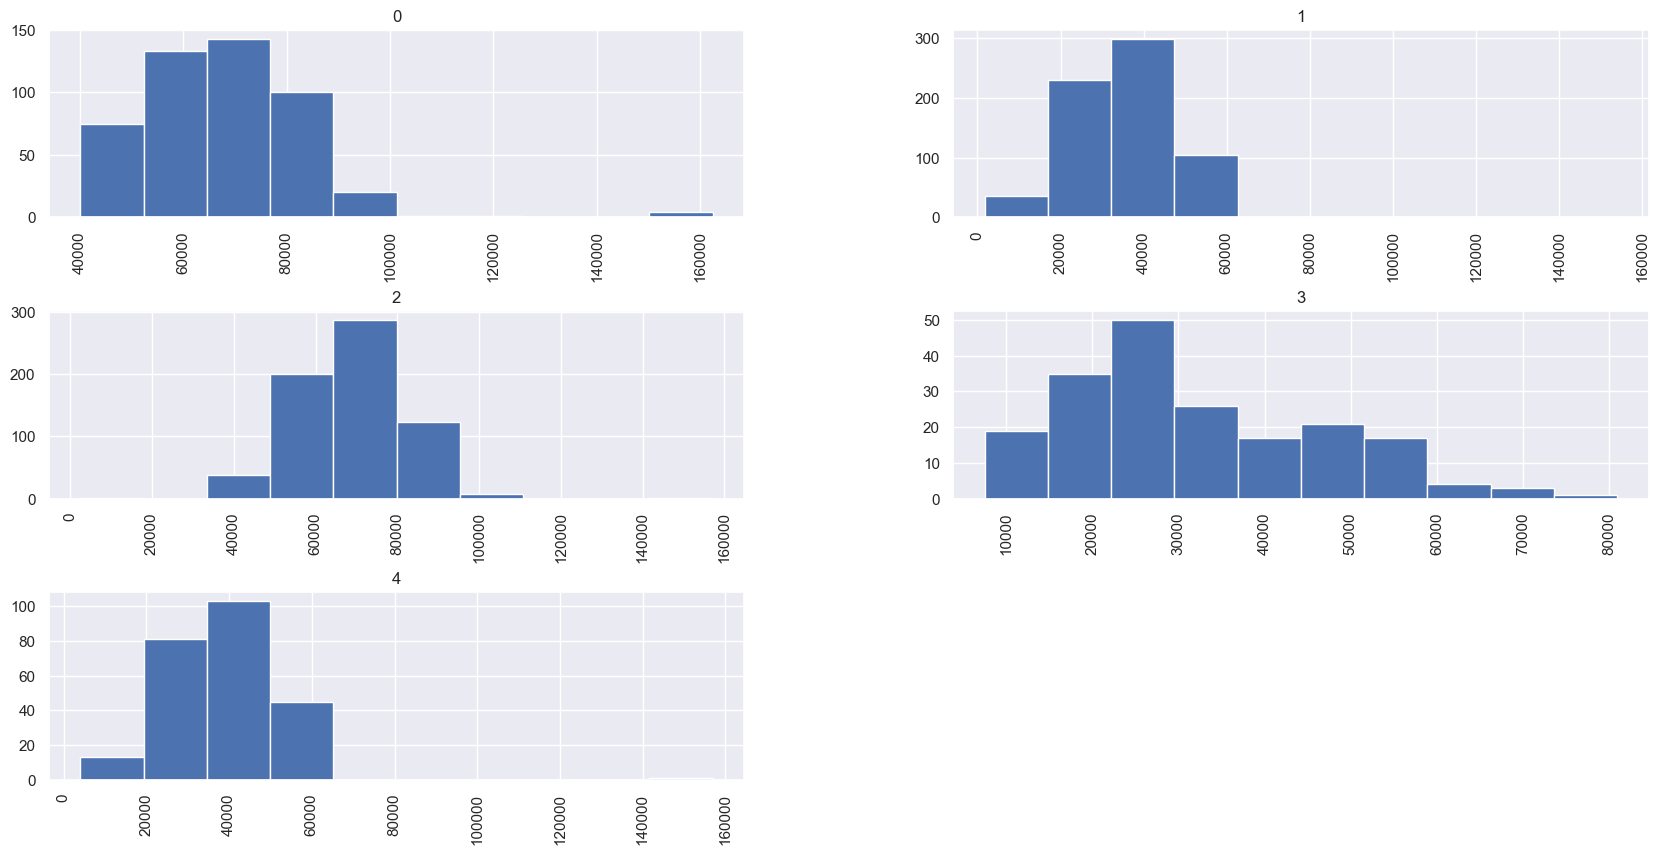

In [140]:
df.hist(column='Income', by='Cluster', figsize=(20,10))
plt.show()

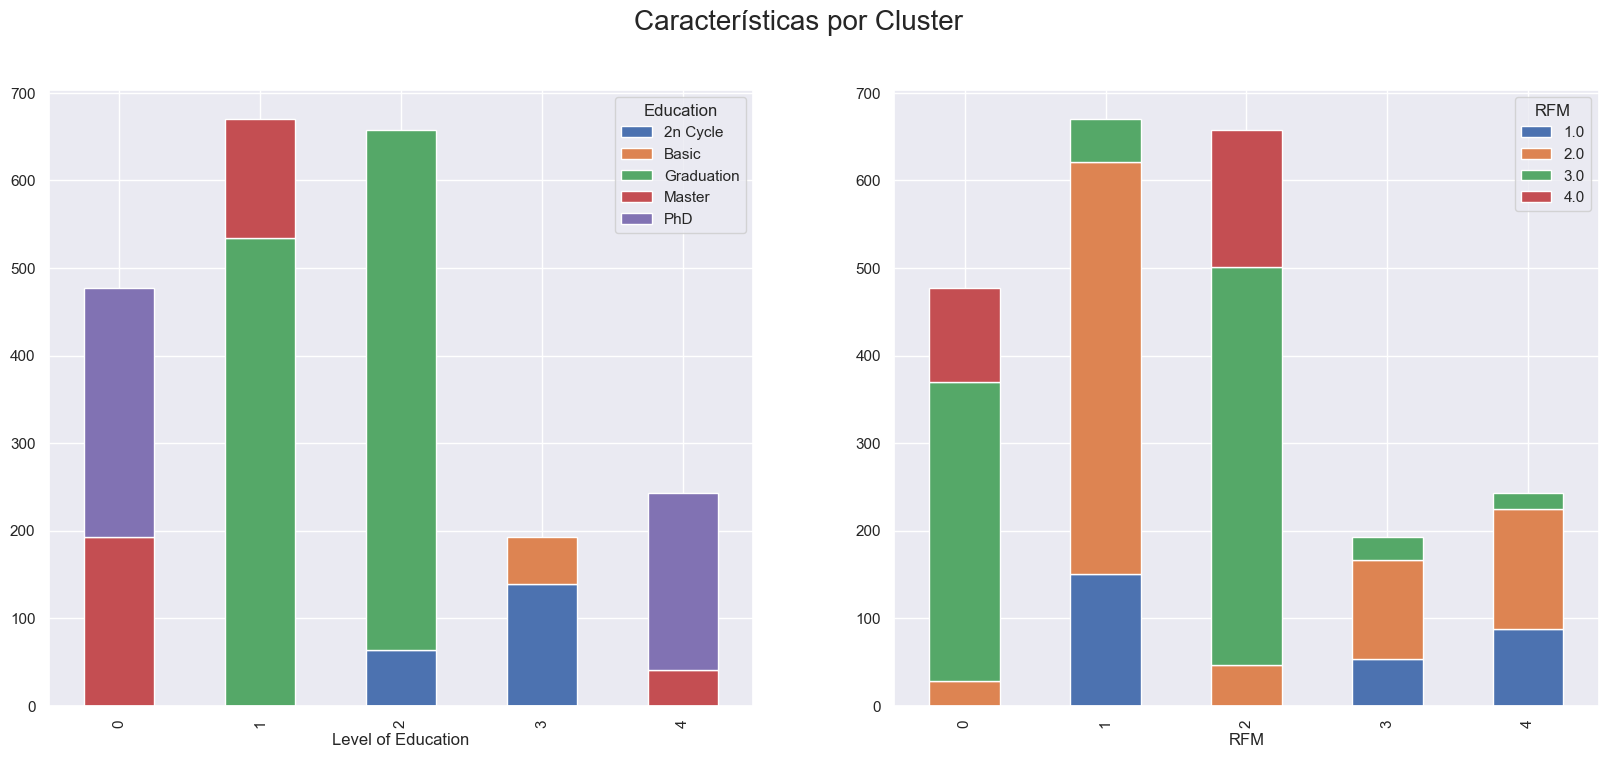

In [177]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.suptitle("Características por Cluster", fontsize=20)

df_edu = df.loc[:, ['Education', 'Cluster']]
df_grouped = df_edu.groupby(['Education', 'Cluster']).agg(count=('Education', 'count')).reset_index()
df_pivot = df_grouped.pivot(index='Cluster', columns='Education', values='count')
graph1 = df_pivot.plot.bar(xlabel='Level of Education', stacked=True, ax=axes[0])

df_rfm = df.loc[:, ['RFM', 'Cluster']]
df_grouped = df_rfm.groupby(['RFM', 'Cluster']).agg(count=('RFM', 'count')).reset_index()
df_pivot = df_grouped.pivot(index='Cluster', columns='RFM', values='count')
graph2 = df_pivot.plot.bar(xlabel='RFM', stacked=True, ax=axes[1])
plt.show()

In [ ]:
df_rfm = df.loc[:, ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Cluster']]
df_grouped = df_rfm.groupby(['Cluster']).agg(count=('Cluster', 'count')).reset_index()
df_pivot = df_grouped.pivot(index='Cluster', columns=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response'], values='count')
graph3 = df_pivot.plot.bar(xlabel='Cluster', stacked=True, ax=axes[2])

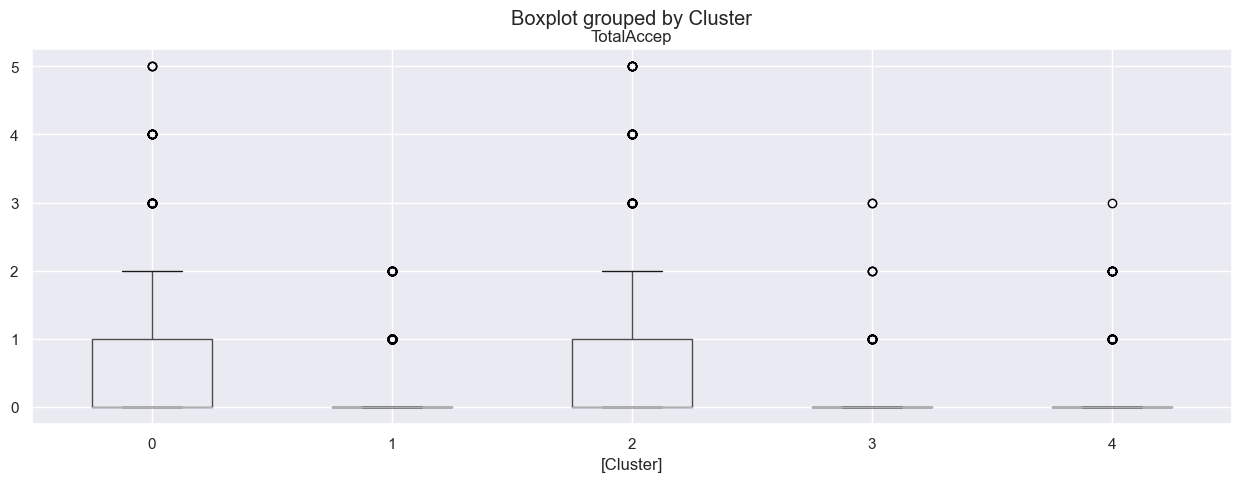

In [178]:
df.loc[:, ['Cluster', 'TotalAccep']].boxplot(by='Cluster')
plt.show()

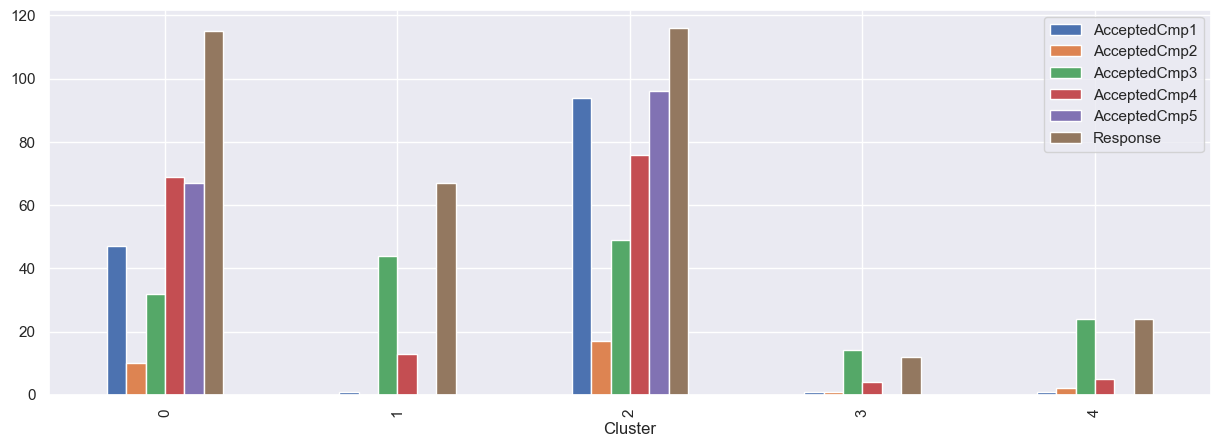

In [187]:
graph1 = df.loc[:, ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Cluster']].groupby('Cluster').sum().plot.bar()
plt.show()

# Previsão

# 1) Preparação da base de dados

In [190]:
df[(df.Response == 1)].shape # 15% da amostra

(334, 40)

In [236]:
X = df.loc[:, ['RFM', 'Education', 'Income', 'AvgMntperPurchase']]
y = df.loc[:, 'Response']
X.shape

(2240, 4)

In [237]:
X['Income'] = X['Income'].apply(lambda x: 0 if (x <= 40000) else x) # baixa
X['Income'] = X['Income'].apply(lambda x: 1 if (x > 40000 and x <= 60000) else x) # média
X['Income'] = X['Income'].apply(lambda x: 2 if (x > 60000) else x) # alta

In [238]:
X['AvgMntperPurchase'].replace(1679.0, X.AvgMntperPurchase.mean(), inplace=True)
X['AvgMntperPurchase'] = X['AvgMntperPurchase'].apply(lambda x: 0 if (x <= 25) else x) # baixa
X['AvgMntperPurchase'] = X['AvgMntperPurchase'].apply(lambda x: 1 if (x > 25 and x <= 50) else x) # média
X['AvgMntperPurchase'] = X['AvgMntperPurchase'].apply(lambda x: 2 if (x > 50) else x) # alta

In [241]:
oe = OrdinalEncoder()
column_transform = make_column_transformer((oe, ['RFM', 'Education', 'Income', 'AvgMntperPurchase']))
X = column_transform.fit_transform(X)

In [192]:
# oversampling
# smote
# regressão logistica com pesos

In [269]:
# Random Oversampler
ros = RandomOverSampler(random_state=32)
X_ros_res, y_ros_res = ros.fit_resample(X, y)
X_ros_train, X_ros_test, y_ros_train, y_ros_test = train_test_split(X_ros_res, y_ros_res, test_size=0.2)

#SMOTE
smote = SMOTE(random_state=32)
X_smote_res, y_smote_res = smote.fit_resample(X, y)
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote_res, y_smote_res, test_size=0.2)

# Árvore de decisão tradicional

In [278]:
class_tree = tree.DecisionTreeClassifier(random_state=32)
class_tree = class_tree.fit(X_ros_train, y_ros_train)
y_pred_ros_tree = class_tree.predict(X_ros_test)
print("F1: ", f1_score(y_ros_test, y_pred_ros_tree))
print("ACC: ", accuracy_score(y_ros_test, y_pred_ros_tree))
print("AUC: ", roc_auc_score(y_ros_test, y_pred_ros_tree))

F1:  0.7215686274509804
ACC:  0.7208387942332897
AUC:  0.7221373415369369


In [279]:
class_tree = tree.DecisionTreeClassifier(random_state=32)
class_tree = class_tree.fit(X_smote_train, y_smote_train)
y_pred_smote_tree = class_tree.predict(X_smote_test)
print("F1: ", f1_score(y_smote_test, y_pred_smote_tree))
print("ACC: ", accuracy_score(y_smote_test, y_pred_smote_tree))
print("AUC: ", roc_auc_score(y_smote_test, y_pred_smote_tree))

F1:  0.7182175622542596
ACC:  0.7182175622542595
AUC:  0.7183175052569372


# Árvore de decisão com Random Forest

In [286]:
randtree = RandomForestClassifier(random_state=32)
randtree = randtree.fit(X_ros_train, y_ros_train)
y_pred_ros_randtree = randtree.predict(X_ros_test)
print("F1: ", f1_score(y_ros_test, y_pred_ros_randtree))
print("ACC: ", accuracy_score(y_ros_test, y_pred_ros_randtree))
print("AUC: ", roc_auc_score(y_ros_test, y_pred_ros_randtree))

F1:  0.7213541666666667
ACC:  0.7195281782437746
AUC:  0.7209845700678588


In [287]:
randtree = RandomForestClassifier(random_state=32)
randtree = randtree.fit(X_smote_train, y_smote_train)
y_pred_smote_randtree = randtree.predict(X_smote_test)
print("F1: ", f1_score(y_smote_test, y_pred_smote_randtree))
print("ACC: ", accuracy_score(y_smote_test, y_pred_smote_randtree))
print("AUC: ", roc_auc_score(y_smote_test, y_pred_smote_randtree))

F1:  0.7289002557544757
ACC:  0.7221494102228048
AUC:  0.7225436703728646


# Regressão logística

In [281]:
logr = LogisticRegression()
logr.fit(X_ros_train, y_ros_train)
# o que eu faço com as probabilidades das estimativas?
y_prob = logr.predict_proba(X_ros_test)
y_pred_ros_logr = logr.predict(X_ros_test)
print("Log loss: ", log_loss(y_ros_test, y_pred_ros_logr))
print("AUC: ", roc_auc_score(y_ros_test, y_pred_ros_logr))

Log loss:  11.090583694342158
AUC:  0.6806616564121623


In [282]:
logr = LogisticRegression()
logr.fit(X_smote_train, y_smote_train)
# o que eu faço com as probabilidades das estimativas?
y_prob = logr.predict_proba(X_smote_test)
y_pred_smote_logr = logr.predict(X_smote_test)
print("Log loss: ", log_loss(y_smote_test, y_pred_smote_logr))
print("AUC: ", roc_auc_score(y_smote_test, y_pred_smote_logr))

Log loss:  11.22637128859922
AUC:  0.6751384670359122
